## Implementing YOLOV2 from scratch using Tensorflow 2.0

## [Paper: YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242)

## Dataset vailable [here](https://www.kaggle.com/kanmeh/fruits-dataset) to **Fruit Detection**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline

# Preparing Data
The data contains the following object classes:

In [2]:
LABELS = ['apple','banana','orange']

In [3]:
train_image_folder = "/kaggle/input/fruits-dataset/train_zip/train/"
train_annot_folder = "/kaggle/input/fruits-dataset/train_zip/train/"

To preprocess the annotations, I will use the pre-processing code at experiencor/keras-yolo2.

**Input :**
1. ann_dir: annotatin directory
2. img_dir: images directory
3. labels: a list of object classes

**Output :**
1. train_image: Each element of the train_image is a dictionary containing the annoation infomation of an image.
2. No_object: Number of images with no objects (unuseful ones)
3. seen_train_labels: seen_train_labels is the dictionary containing (key, value) = (the object class, the number of objects found in the images)


In [4]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    - No_object Number of images with no objects (unuseful ones)        
    '''
    all_imgs = []
    seen_labels = {}
    No_object=0
    for ann in sorted(os.listdir(ann_dir)):
        
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
#                 print(path_to_image)
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                                                    
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0 and img['width']!=0 and img['height']!=0:
            all_imgs += [img]
        else:
            No_object=No_object+1

                
              
    return all_imgs,No_object, seen_labels
## Parse annotations 
train_image,No_object, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print('Number of images with no objects (unuseful ones) =', No_object)     
print("Number of train images= {}".format(len(train_image)))

Number of images with no objects (unuseful ones) = 33
Number of train images= 207


In [5]:
print("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)))

The total number of objects = 465 in 207 images


# Reviwing one Sample data

In [6]:
import random
i= random.randint(0,len(train_image))
train_image[0]

{'object': [{'name': 'apple',
   'xmin': 56,
   'ymin': 99,
   'xmax': 1413,
   'ymax': 1419}],
 'filename': '/kaggle/input/fruits-dataset/train_zip/train/apple_10.jpg',
 'width': 1500,
 'height': 1500}

Number of Fruits =  5


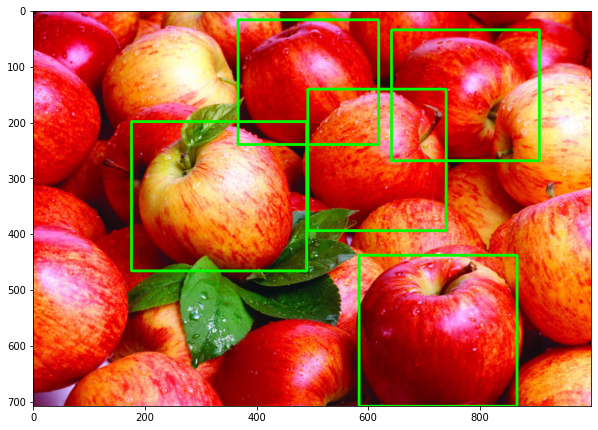

In [96]:
def ShowImage(image,ax):
    img_path=image['filename']
    objects=image['object']
    
    img=plt.imread(img_path)
    # ax.imshow(img)
    print("Number of Fruits = ", len(objects))
    for bbox in objects:   
        (x1,y1,x2,y2)=bbox['xmin'],bbox['ymin'],bbox['xmax'],bbox['ymax']
        out=cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),4)
        ax.imshow(out)
        
fig, ax = plt.subplots(1, 1, figsize=(10, 10))        
ShowImage(train_image[i],ax)

## Parepare (width, height) data for K-means clustering
YOLO9000:Better, Faster, Stronger suggests to use clustering on bounding box shape to find the good anchor box specialization suited for the data.

First feature data for K-means clustering are prepared. The data contain standardized width and height (the bounding box width and hight are standardized with its image width and height as the image width and height differ across images)

In [8]:
wh = []
for anno in train_image:
    aw = float(anno['width'])  # width of the original image
    ah = float(anno['height']) # height of the original image
    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"])/aw # make the width range between [0,GRID_W)
        h = (obj["ymax"] - obj["ymin"])/ah # make the width range between [0,GRID_H)
        temp = [w,h]
        wh.append(temp)
wh = np.array(wh)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (420, 2)


## Visualize the clustering data

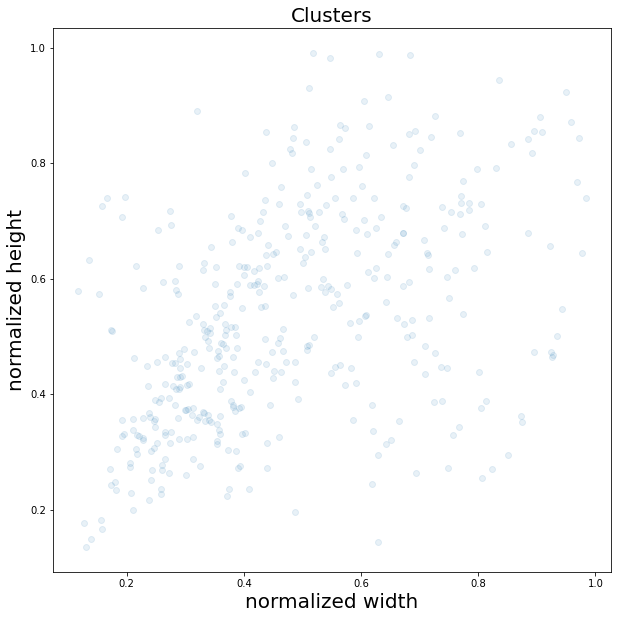

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(wh[:,0],wh[:,1],alpha=0.1)
plt.title("Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

# Intersection over union

In [10]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

# The k-means clustering

The k-mean clustering has two simple steps:

Set the number of clusters and initialize the cluster centers

*  Step 1: allocate each item to the closest cluster centers(the distance to the cluster center is calculated using 1 - IOU).
* Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters(used median to calculate the cluster centers). 

Repeat steps 1 and 2 until the two consective iterations yield the same cluster centers.


In [11]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

We need to decide how many anchor boxes we should create and the specialization of each anchor boxshapes. To find answer to these hyperparameter values,  k-means clustering for k = 2,3,...,10 are tried.

The more clusters, the larger mean IoU becomes. This is expected as in ultimate case, when k = N cases, then the mean IoU must be 1.

In [12]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.6669
 3 clusters: mean IoU = 0.6988
 4 clusters: mean IoU = 0.7354
 5 clusters: mean IoU = 0.7561
 6 clusters: mean IoU = 0.7710
 7 clusters: mean IoU = 0.7747
 8 clusters: mean IoU = 0.7897
 9 clusters: mean IoU = 0.7997
10 clusters: mean IoU = 0.8051


## Selecting anchor boxes

4 anchor boxes may be a good size, the width and heights range between 0 and 1.

In [13]:
Nanchor_box = 5
_ANCHORS01 = results[Nanchor_box]["clusters"]
_ANCHORS01

array([[0.22720386, 0.35547796],
       [0.7393937 , 0.75758688],
       [0.47440328, 0.66544684],
       [0.36066006, 0.43439479],
       [0.70907417, 0.41612267]])

# Input/output encoding

The input encoding essentialily only requires to readin an image and resize it to the pre-specified shape.

Accordingly, the output's xmin, ymin, xmax and ymax also need to be resized. This is the first step of output encoding.

The **ImageReader** class below does the first step of input and output encoding.

In [14]:
import copy
class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        '''
        IMAGE_H : the height of the rescaled image, e.g., 416
        IMAGE_W : the width of the rescaled image, e.g., 416
        '''
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        # resize the image to standard size
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        
        -- Input -- 
        
        train_instance : dictionary containing filename, height, width and object
        
        {'object': [{'name': 'weed','xmin': 413,'ymin': 266,'xmax': 455,'ymax': 279}],
                     'filename': '/kaggle/input/weed-detection/Ronin_OPEN_DB/raw images/32952.jpg',
                     'width': 1280,
                     'height': 720}
         '''
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = cv2.imread(image_name)
        h, w, c = image.shape
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

## Example useage of InputEncoder
Notice that the despite the original image is size (1280,720,3), the encoded image is of shape (416,416,3). The xmin, xmax, ymin and ymax annotations are also rescaled accordingly.

******************************
Input
  object: [{'name': 'apple', 'xmin': 56, 'ymin': 99, 'xmax': 1413, 'ymax': 1419}]
  filename: /kaggle/input/fruits-dataset/train_zip/train/apple_10.jpg
  width: 1500
  height: 1500
******************************
Output
          [{'name': 'apple', 'xmin': 15, 'ymin': 27, 'xmax': 391, 'ymax': 393}]


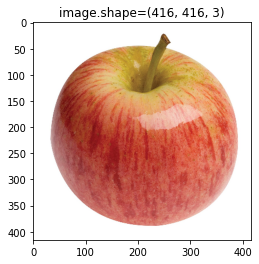

In [15]:
def normalize(image):
    return image / 255.

print("*"*30)
print("Input")
timage = train_image[0]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("          {}".format(all_objs))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

## Output encoding 1:
Assign each object to a ground truth anchor box.

Each object in a training image is assigned to grid cell that contains object’s midpoint and anchor box for the grid cell with the highest IoU.

**BestAnchorBoxFinder** class below finds the best anchor box for given candidate anchor boxes.

In [16]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.
        
        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        # Since only the values of iou are important, all BoundBox are considered at position (0,0) with (w,h)=xmax, ymax
        # think that the xmin and ymin are shared by the two objects. 
        
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence      = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])

### Example to try BestAnchorBoxFinder

In [17]:
_ANCHORS01=_ANCHORS01.reshape(-1)
print(".."*40)
print("The three example anchor boxes:")
count = 0
for k in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[k],_ANCHORS01[k+1]))
    count += 1
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1,5):
    w =random.random()
    h =random.random()
    best_anchor,max_iou = babf.find(w,h)
    print("object with bounding box (0,0 , w = {}, h = {}) has best anchor box :index = {}, iou = {:03.2f}".format(
            w,h,best_anchor,max_iou))

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.22720385585560515, h=0.35547795538946314
anchor box index=1, w=0.7393936995528873, h=0.7575868795160243
anchor box index=2, w=0.4744032751344283, h=0.6654468391336354
anchor box index=3, w=0.36066006375782833, h=0.43439479323515934
anchor box index=4, w=0.7090741715219548, h=0.416122667013958
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
object with bounding box (0,0 , w = 0.30390463962942904, h = 0.6914113363691455) has best anchor box :index = 2, iou = 0.62
object with bounding box (0,0 , w = 0.8912156987201502, h = 0.32944396305128987) has best anchor box :index = 4, iou = 0.66
object with bounding box (0,0 , w = 0.23931395389850074, h = 0.7108299855922541) has best anchor box :index = 2, iou = 0.49
object with bounding box (0,0 , w = 0

## Output encoding 2:
Bounding box encoding:
In this input encoding, each object in a frame is recorded in xmin, ymin, xmax and ymax coordiante formats, however in YOLO, we need outputs of the bounding box coordinates in the 'center_x', 'center_y', 'center_w', 'center_h' format.

Rescale the unit of bounding box coordinates to the grid cell scales

Above, the unit of bounding box is pixel. However, in YOLO, the unit needs to be "grid cell" scale.

Grid cells
YOLO devides an image into grid cells (e.g. 13 by 13 grid cells) and assign image classification and localization algorithms in each of the grid cell. See Andrew Ng's lecture below.

For example, as the center width is 150 pixels, if there are 13 grid cells along the horizontal axis, then the center width must be recorded in grid cell scale as:
150/416∗13=4.6875

In [18]:
def rescale_centerxy(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = .5*(obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5*(obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_centerwh(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''    
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w,center_h)

Example useage of rescale_centerxy and rescale_centerwh¶


In [19]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}
center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_centerwh(obj,config)

print("center_x abd center_w should range between 0 and {}".format(config["GRID_W"]))
print("center_y abd center_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

center_x abd center_w should range between 0 and 13
center_y abd center_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


# Keras's BatchGenerator
Keras generator is to get batches of input and corresponding output on the fly during training process, e.g. reading in 100 images, getting corresponding 100 label vectors and then feeding this set to the gpu for training step. 

In [20]:
from keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        '''
        config : dictionary containing necessary hyper parameters for traning. e.g., 
            {
            'IMAGE_H'         : 416, 
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,  
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,  
                                        2.71054693,   5.12469308, 
                                        10.47181473, 10.09646365,  
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }
        
        '''
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_centerwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

## Experiment with BatchGenerator¶
_ANCHORS01 is defined to range between 0 and 1. However, as the bounding box's center_w and center_h are in the grid cell scales, we also need to adjust the width and height of the anchor boxes to be in the grid scales.

In [21]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS 

array([2.95365013, 4.62121342, 9.61211809, 9.84862943, 6.16724258,
       8.65080891, 4.68858083, 5.64713231, 9.21796423, 5.40959467])

In [22]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 32
TRUE_BOX_BUFFER  = 50
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

## Input/Output shape¶


In [23]:
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (32, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (32, 13, 13, 5, 8)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (32, 1, 1, 1, 50, 4)


## Check which (grid cell, Anchor box) pair contains objects

In [24]:
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))

## Visualize the output of the BatchGenerator

In [25]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)      

igrid_h=05,igrid_w=04,iAnchor=02, orange
igrid_h=06,igrid_w=08,iAnchor=02, orange


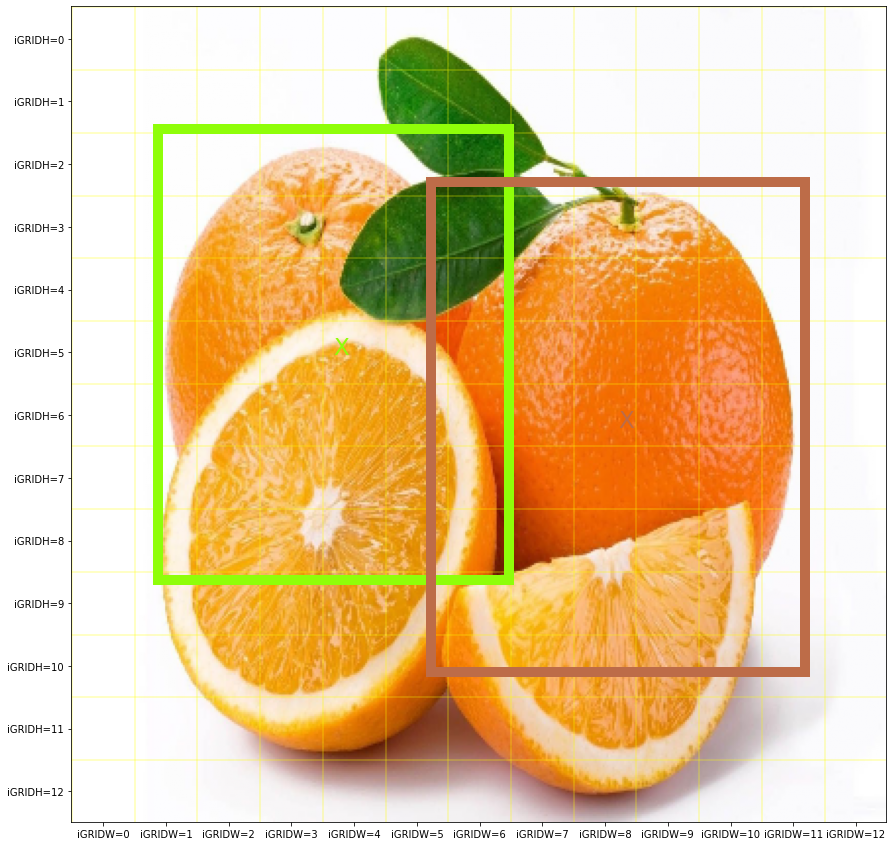

In [26]:
iframe= random.randint(0,BATCH_SIZE-1)
check_object_in_grid_anchor_pair(iframe)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()


# YOLOv2 Model Architecture
the model architecture is simple. It repeatedly stacks Convolusion + Batch Normalization + Leaky Relu layers until the image shape reduces to the grid cell size. 

In [27]:
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
CLASS             = len(LABELS)

In [28]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.compat.v1.space_to_depth(x, block_size=2)

def ConvBatchLReLu(x,filters,kernel_size,index,trainable):
    # when strides = None, strides = pool_size.
    x = Conv2D(filters, kernel_size, strides=(1,1), 
               padding='same', name='conv_{}'.format(index), 
               use_bias=False, trainable=trainable)(x)
    x = BatchNormalization(name='norm_{}'.format(index), trainable=trainable)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return(x)
def ConvBatchLReLu_loop(x,index,convstack,trainable):
    for para in convstack:
        x = ConvBatchLReLu(x,para["filters"],para["kernel_size"],index,trainable)
        index += 1
    return(x)
def define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, trainable=False):
    convstack3to5  = [{"filters":128, "kernel_size":(3,3)},  # 3
                      {"filters":64,  "kernel_size":(1,1)},  # 4
                      {"filters":128, "kernel_size":(3,3)}]  # 5
                    
    convstack6to8  = [{"filters":256, "kernel_size":(3,3)},  # 6
                      {"filters":128, "kernel_size":(1,1)},  # 7
                      {"filters":256, "kernel_size":(3,3)}]  # 8
    
    convstack9to13 = [{"filters":512, "kernel_size":(3,3)},  # 9
                      {"filters":256, "kernel_size":(1,1)},  # 10
                      {"filters":512, "kernel_size":(3,3)},  # 11
                      {"filters":256, "kernel_size":(1,1)},  # 12
                      {"filters":512, "kernel_size":(3,3)}]  # 13
        
    convstack14to20 = [{"filters":1024, "kernel_size":(3,3)}, # 14 
                       {"filters":512,  "kernel_size":(1,1)}, # 15
                       {"filters":1024, "kernel_size":(3,3)}, # 16
                       {"filters":512,  "kernel_size":(1,1)}, # 17
                       {"filters":1024, "kernel_size":(3,3)}, # 18
                       {"filters":1024, "kernel_size":(3,3)}, # 19
                       {"filters":1024, "kernel_size":(3,3)}] # 20
    
    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3),name="input_image")
    true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4),name="input_hack")    
    # Layer 1
    x = ConvBatchLReLu(input_image,filters=32,kernel_size=(3,3),index=1,trainable=trainable)
    
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_416to208")(x)
    # Layer 2
    x = ConvBatchLReLu(x,filters=64,kernel_size=(3,3),index=2,trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_208to104")(x)
    
    # Layer 3 - 5
    x = ConvBatchLReLu_loop(x,3,convstack3to5,trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_104to52")(x)
    
    # Layer 6 - 8 
    x = ConvBatchLReLu_loop(x,6,convstack6to8,trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_52to26")(x) 

    # Layer 9 - 13
    x = ConvBatchLReLu_loop(x,9,convstack9to13,trainable)
        
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_26to13")(x)
    
    # Layer 14 - 20
    x = ConvBatchLReLu_loop(x,14,convstack14to20,trainable)

    # Layer 21
    skip_connection = ConvBatchLReLu(skip_connection,filters=64,
                                     kernel_size=(1,1),index=21,trainable=trainable)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = ConvBatchLReLu(x,filters=1024,kernel_size=(3,3),index=22,trainable=trainable)

    # Layer 23
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS),name="final_output")(x)

    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0],name="hack_layer")([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    return(model, true_boxes)


## true_boxes is the tensor that takes "b_batch"
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           norm_1[0][0]                     
______________________________________________________________________________________________

# Load pre-trained YOLOv2 weights

In [29]:
!wget https://pjreddie.com/media/files/yolov2.weights
path_to_weight = "./yolov2.weights"

--2021-07-08 05:40:42--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  62.5MB/s    in 3.1s    

2021-07-08 05:40:45 (62.5 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



The following codes are extracted from keras-yolo2/Yolo Step-by-Step.ipynb

In [30]:
class WeightReader:
    # code from https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
                
weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


Assign pre-trained weights to the following layers: conv_i, norm_i, i = 1, 2,..., 22. These layers do not depend on the number of object classes or the number of anchor boxes.

In [31]:
def set_pretrained_weight(model,nb_conv, path_to_weight):
    weight_reader = WeightReader(path_to_weight)
    weight_reader.reset()
    for i in range(1, nb_conv+1):
        conv_layer = model.get_layer('conv_' + str(i)) ## convolusional layer

        if i < nb_conv:
            norm_layer = model.get_layer('norm_' + str(i)) ## batch normalization layer

            size = np.prod(norm_layer.get_weights()[0].shape)

            beta  = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean  = weight_reader.read_bytes(size)
            var   = weight_reader.read_bytes(size)

            weights = norm_layer.set_weights([gamma, beta, mean, var])       

        if len(conv_layer.get_weights()) > 1: ## with bias
            bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else: ## without bias
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])
    return(model)


nb_conv = 23
model = set_pretrained_weight(model,nb_conv, path_to_weight)

# Initialize the 23rd layer

In [32]:
def initialize_weight(layer):
    weights = layer.get_weights()
    
    new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
    new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)
    
    layer.set_weights([new_kernel, new_bias])
    
layer   = model.layers[-4] # the last convolutional layer

initialize_weight(layer)


# YOLOv2's loss function

## For more detail see[ here](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html)  and experiencor/keras-yolo2's YOLO V2 loss [here](https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb).¶


In [33]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [34]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 

In [35]:
def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of 
    
    ### adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)

In [36]:
def print_min_max(vec,title):
  try:
    print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))
  except ValueError:  #raised if `y` is empty.
      pass

In [37]:
print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 

print("\npred_box_xy {}".format(pred_box_xy.shape)) 

for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0],
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1],
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf,"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class,"  class probability") 

******************************
prepare inputs
y_pred before scaling = (32, 13, 13, 5, 8)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (32, 13, 13, 5, 2)
  bounding box x at iGRID_W=00 MIN= 0.45, MAX= 0.55
  bounding box x at iGRID_W=01 MIN= 1.46, MAX= 1.55
  bounding box x at iGRID_W=02 MIN= 2.46, MAX= 2.55
  bounding box x at iGRID_W=03 MIN= 3.45, MAX= 3.55
  bounding box x at iGRID_W=04 MIN= 4.45, MAX= 4.55
  bounding box x at iGRID_W=05 MIN= 5.45, MAX= 5.55
  bounding box x at iGRID_W=06 MIN= 6.46, MAX= 6.55
  bounding box x at iGRID_W=07 MIN= 7.45, MAX= 7.55
  bounding box x at iGRID_W=08 MIN= 8.45, MAX= 8.55
  bounding box x at iGRID_W=09 MIN= 9.45, MAX= 9.57
  bounding box x at iGRID_W=10 MIN=10.45, MAX=10.55
  bounding box x at iGRID_W=11 MIN=11.44, MAX=11.56
  bounding box x at iGRID_W=12 MIN=12.45, MAX=12.55
  bounding box y at iGRID_H=00 MIN= 0.45, MAX= 0.56
  bounding box y at iGRID_H=01 M

In [38]:
def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [39]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0]
    pick = true_box_conf[:,:,igrid_w,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1]
    pick = true_box_conf[:,igrid_h,:,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0],"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1],"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class)) )

Input y_batch = (32, 13, 13, 5, 8)
******************************
ouput
******************************

true_box_xy (32, 13, 13, 5, 2)
  bounding box x at iGRID_W=01 MIN= 1.81, MAX= 1.81
  bounding box x at iGRID_W=03 MIN= 3.98, MAX= 3.98
  bounding box x at iGRID_W=04 MIN= 4.17, MAX= 4.98
  bounding box x at iGRID_W=05 MIN= 5.06, MAX= 5.98
  bounding box x at iGRID_W=06 MIN= 6.12, MAX= 6.97
  bounding box x at iGRID_W=07 MIN= 7.09, MAX= 7.80
  bounding box x at iGRID_W=08 MIN= 8.31, MAX= 8.73
  bounding box x at iGRID_W=09 MIN= 9.20, MAX= 9.98
  bounding box x at iGRID_W=10 MIN=10.03, MAX=10.70
  bounding box y at iGRID_H=02 MIN= 2.56, MAX= 2.97
  bounding box y at iGRID_H=03 MIN= 3.09, MAX= 3.98
  bounding box y at iGRID_H=04 MIN= 4.47, MAX= 4.86
  bounding box y at iGRID_H=05 MIN= 5.09, MAX= 5.83
  bounding box y at iGRID_H=06 MIN= 6.02, MAX= 6.97
  bounding box y at iGRID_H=07 MIN= 7.11, MAX= 7.92
  bounding box y at iGRID_H=08 MIN= 8.03, MAX= 8.95
  bounding box y at iGRID_H=09 MI

In [40]:
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh): 
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * LAMBDA_COORD 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord_mask)

In [41]:
LAMBDA_COORD = 1
loss_xywh, coord_mask  = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy,true_box_wh, pred_box_wh)

print("*"*30 + "\nouput\n" + "*"*30)

print("loss_xywh = {:4.3f}".format(loss_xywh))

******************************
ouput
******************************
loss_xywh = 1.463


In [42]:
def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)

In [43]:
LAMBDA_CLASS   = 1
loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                 true_box_class,pred_box_class)
print("*"*30 + "\nouput\n" + "*"*30) 
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_class = 1.103


In [44]:
def get_intersect_area(true_xy,true_wh,
                       pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)

******************************
input
******************************
******************************
ouput
******************************
true_box_conf_IOU.shape = (32, 13, 13, 5)


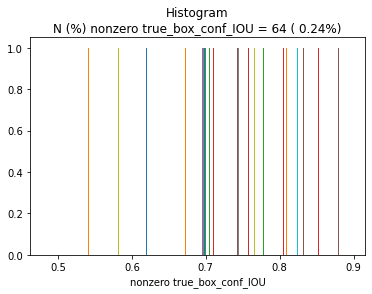

In [45]:
true_box_conf_IOU = calc_IOU_pred_true_assigned(
                            true_box_conf,
                            true_box_xy, true_box_wh,
                            pred_box_xy,  pred_box_wh)

print("*"*30 + "\ninput\n" + "*"*30)    
# print("true_box_conf = {}".format(true_box_conf))
# print("true_box_xy   = {}".format(true_box_xy))
# print("true_box_wh   = {}".format(true_box_wh))
# print("pred_box_xy   = {}".format(pred_box_xy))
# print("pred_box_wh   = {}".format(pred_box_wh))
print("*"*30 + "\nouput\n" + "*"*30) 
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))
vec  = true_box_conf_IOU
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

In [46]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)

In [47]:
true_boxes = tf.constant(b_batch,dtype="float32")
best_ious = calc_IOU_pred_true_best(pred_box_xy,
                                       pred_box_wh,
                                       true_boxes)
    
# print("*"*30 + "\ninput\n" + "*"*30)    
# print("true_box_wh   = {}".format(true_box_wh))
# print("pred_box_xy   = {}".format(pred_box_xy))
# print("pred_box_wh   = {}".format(pred_box_wh))
# print("*"*30 + "\nouput\n" + "*"*30) 
# print("best_ious.shape = {}".format(best_ious.shape))
# vec  = best_ious
# pick = vec!=0
# vec  = vec[pick]
# plt.hist(vec)
# plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
#                                                              100*np.mean(pick)))
# plt.xlabel("nonzero best_ious")
# plt.show()

In [48]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

In [49]:
conf_mask = get_conf_mask(best_ious, 
                             true_box_conf, 
                             true_box_conf_IOU,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)
# print("*"*30 + "\ninput\n" + "*"*30)  
# print("best_ious         = {}".format(best_ious)) 
# print("true_box_conf     = {}".format(true_box_conf))
# print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
# print("LAMBDA_NO_OBJECT  = {}".format(LAMBDA_NO_OBJECT)) 
# print("LAMBDA_OBJECT     = {}".format(LAMBDA_OBJECT))

# print("*"*30 + "\noutput\n" + "*"*30)      
# print("conf_mask shape = {}".format(conf_mask.shape))

In [50]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

In [51]:
# print("*"*30 + "\ninput\n" + "*"*30)  
# print("conf_mask         = {}".format(conf_mask)) 
# print("true_box_conf_IOU = {}".format(true_box_conf_IOU))
# print("pred_box_conf     = {}".format(pred_box_conf))

# loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    
# print("*"*30 + "\noutput\n" + "*"*30)      
# print("loss_conf = {:5.4f}".format(loss_conf))

In [52]:
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
        
    '''
    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss


In [53]:
print(y_batch.dtype, y_pred.dtype)
true_boxes = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32')) 
print('loss', loss)

float64 float64
loss tf.Tensor(2.6913133, shape=(), dtype=float32)


## Training

In [54]:
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass

BATCH_SIZE = 32
generator_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('./output/kaggle/working/weights_yolo2_fruit_detection.h5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=100)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# optimizer = Adam(lr=0.1)

model.compile(loss=custom_loss ,optimizer=optimizer) 

In [55]:
tf.config.experimental_run_functions_eagerly(True)

model.fit_generator(generator        = train_batch_generator, 
                    steps_per_epoch  = len(train_batch_generator), 
                    epochs           = 250, 
                    verbose          = 1,
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/250
7/7 [==============================] - 12s 839ms/step - loss: 3.3982
Epoch 2/250
7/7 [==============================] - 6s 793ms/step - loss: 3.0035
Epoch 3/250
7/7 [==============================] - 6s 728ms/step - loss: 2.8012
Epoch 4/250
7/7 [==============================] - 5s 721ms/step - loss: 2.5560
Epoch 5/250
7/7 [==============================] - 6s 752ms/step - loss: 2.3187
Epoch 6/250
7/7 [==============================] - 5s 716ms/step - loss: 2.1336
Epoch 7/250
7/7 [==============================] - 6s 766ms/step - loss: 1.9814
Epoch 8/250
7/7 [==============================] - 6s 798ms/step - loss: 1.9407
Epoch 9/250
7/7 [==============================] - 6s 767ms/step - loss: 1.7608
Epoch 10/250
7/7 [==============================] - 5s 739ms/step - loss: 1.6827
Epoch 11/250
7/7 [==============================] - 6s 753ms/step - loss: 1.6444
Epoch 12/250
7/7 [==============================] - 5s 725ms/step - loss: 1.6162
Epoch 13/250
7/7 [==================

# Saving

In [63]:
# model.save_weights("weights_yolo2_fruit_detection.h5")
# serialize model to JSON and serialize weights to HDF5

model_json = model.to_json()
with open("weights_yolo2_fruit_detection.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("weights_yolo2_fruit_detection.h5")
print("Saved model to disk")

Saved model to disk


# Evaluation
To predict the class labels and bounding boxes for the unseen images.

## OutputRescaler 

In [57]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

## Find high class_probability for every (grid , anchor) 

In [58]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)

## Visualization

In [125]:
import cv2, copy
import seaborn as sns
def draw_boxes(image_raw,image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

    ShowImage(image_raw,ax1)
    
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:10}{:4.2f}".format(labels[box.label], box.get_score())
#         print(xmin,ymin,xmax,ymax)
#         if verbose:
#             print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        out1=cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (255,0,0), 2)
        out=cv2.putText(img       = out1, 
                    text      = text, 
                    org       = (xmin+ 0, ymin - 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 0.002 * image_h,
                    color     = (255, 0, 0),
                    thickness = 2)
        ax2.imshow(out)
    return image


## Non max_suppression

In [60]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS    = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
                        
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]                
    
    return newboxes 

## Test Data

In [61]:
test_image_folder = "/kaggle/input/fruits-dataset/test_zip/test/"
test_annot_folder = "/kaggle/input/fruits-dataset/test_zip/test/"

test_image,No_object, seen_test_labels = parse_annotation(test_annot_folder,test_image_folder, labels=LABELS)
print('Number of images with no objects (unuseful ones) =', No_object)     
print("Number of test images= {}".format(len(test_image)))

Number of images with no objects (unuseful ones) = 4
Number of test images= 56


(416, 416, 3)
(5, 416, 416, 3)
Number of Fruits =  1
Number of Fruits =  1
Number of Fruits =  2
Number of Fruits =  1
Number of Fruits =  2


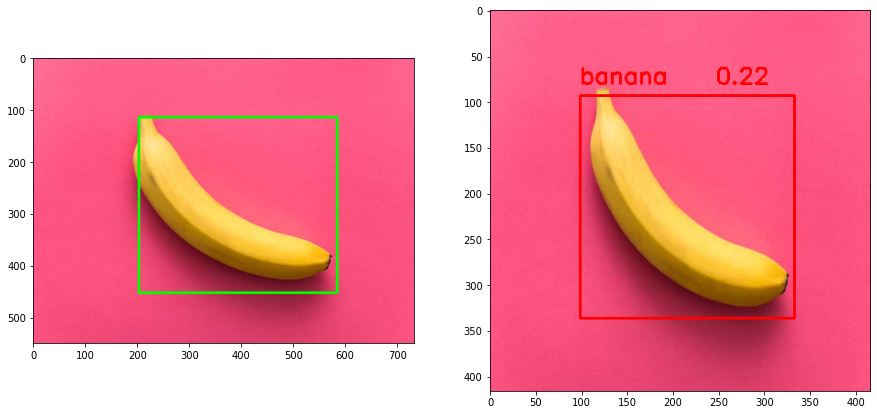

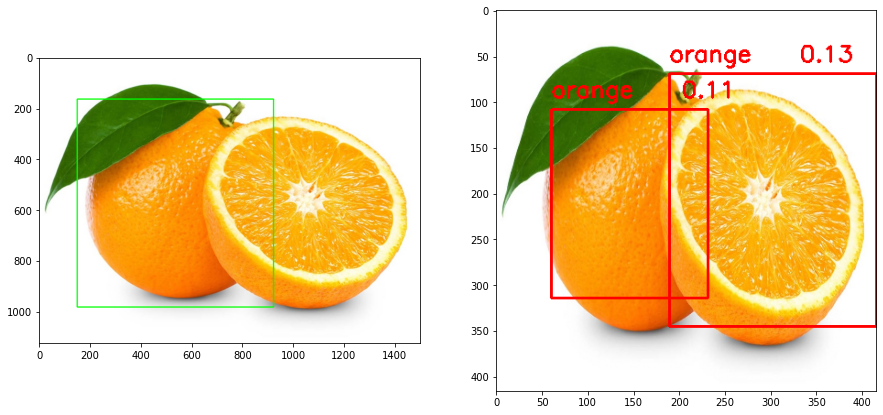

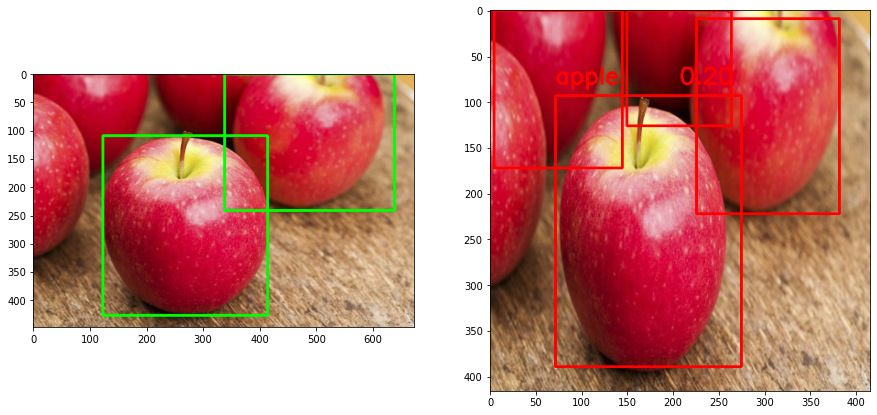

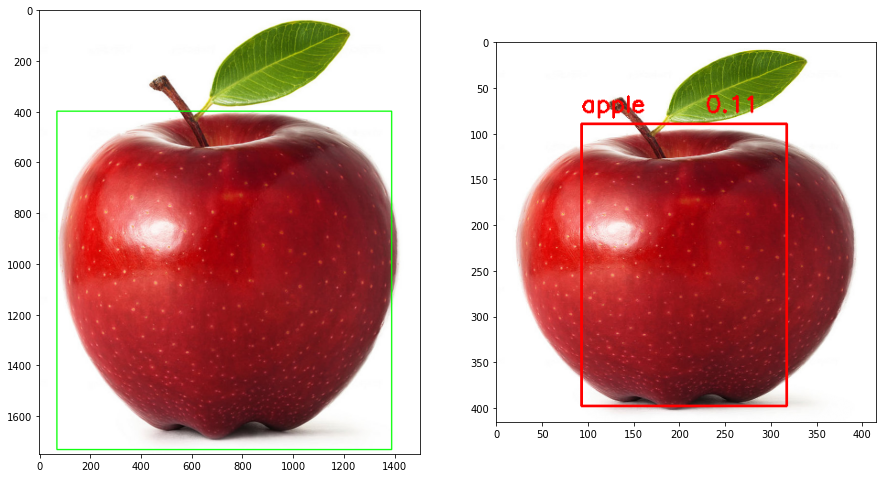

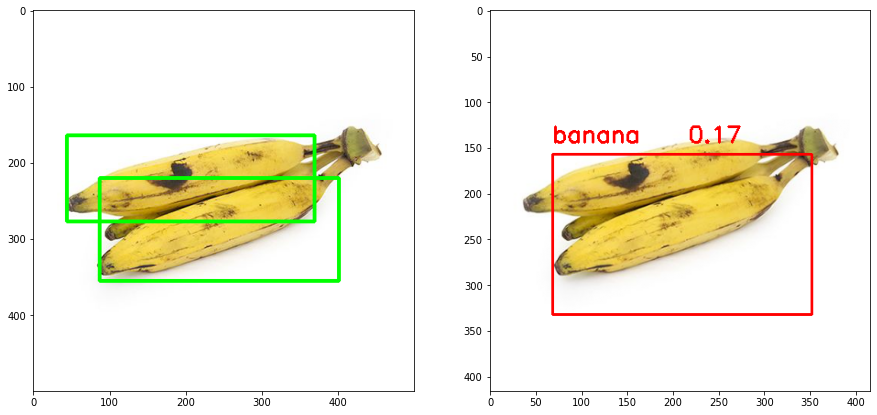

In [161]:
obj_threshold = 0.1
iou_threshold = 0.1
Nsample   =5
figsize = (10,10)
image_nms = list(np.random.choice(test_image,Nsample))
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
imageReader    = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)

X_test         = []
for img_nm in image_nms:
    _path    = img_nm['filename']
    out      = imageReader.fit(_path)
#     ShowImage(img_nm)
    X_test.append(out)
    
print(X_test[0].shape)

X_test = np.array(X_test)

## model
dummy_array    = np.zeros((len(X_test),1,1,1,TRUE_BOX_BUFFER,4))
print(X_test.shape)
y_pred         = model.predict([X_test,dummy_array])

for iframe in range(len(y_pred)):
        netout         = y_pred[iframe] 
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,
                                                iou_threshold=iou_threshold,
                                                obj_threshold=obj_threshold)
            ima = draw_boxes(image_nms[iframe],X_test[iframe],final_boxes,LABELS,verbose=True)
#             ShowImage(image_nms[0])
#             plt.figure(figsize=figsize)
#             plt.imshow(ima); 
#             plt.show()

# References:

Thanks to  Yumi's Blog [See here](https://fairyonice.github.io/tag/object-detection-using-yolov2-on-pascal-voc2012-series.html)

Thanks to Vivek Maskara [See here](https://www.maskaravivek.com/post/yolov2/)
